# Ground removal
* PCA
* RANSAC

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import math
import copy
import os
from mayavi import mlab
from tools.ground_removal import *
from tools.ground_removal_kitti import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
pts, intens = get_frame(10)
ground_mask = get_frame_ground_mask(10)
number_of_ground_points = ground_mask.sum()
no_ground_mask = get_frame_without_ground_mask(10)



In [66]:
# plot whole PCL
mlab.points3d(pts[:,0], pts[:,1], pts[:,2], intens, mode='point')
mlab.show()

In [53]:
# plot only ground
mlab.points3d(pts[ground_mask][:,0], pts[ground_mask][:,1], pts[ground_mask][:,2], intens[ground_mask], mode='point')
mlab.show()

In [55]:
# plot PCL with ground removed
mlab.points3d(pts[no_ground_mask][:,0], pts[no_ground_mask][:,1], pts[no_ground_mask][:,2], intens[no_ground_mask], mode='point')
mlab.show()

## PCA

In [102]:
# PCA
inliers_idx, outliers_idx = find_PCA_inliers_outliers(pts, 0.2, True)
inliers = pts[inliers_idx]
inliers_intens = intens[inliers_idx]
outliers_intens = intens[outliers_idx]
outliers = pts[outliers_idx]

pca_idx = np.zeros((pts.shape[0]))
pca_idx[inliers_idx] = 1

precision, recall, iou = calculate_metrics(pca_idx,ground_mask)

print(f"PCA: precision = {precision * 100 :.2f}%, recall = {recall * 100 :.2f}%,"\
      f"iou = {iou * 100 :.2f}%")
mlab.points3d(outliers[:, 0], outliers[:, 1], outliers[:, 2], outliers_intens, mode='point')
mlab.points3d(inliers[:, 0], inliers[:, 1], inliers[:, 2], color=(1,0,0), mode='point')
mlab.show()


PCA: precision = 91.85%, recall = 33.03%,iou = 32.09%


## RANSAC

In [104]:
# Ransac
inliers_idx, outliers_idx = ransac(pts, 10, 0.2, len(pts)/5)

inliers = pts[inliers_idx]
outliers = pts[outliers_idx]
outliers_intens = intens[outliers_idx]

ransac_idx = np.zeros((pts.shape[0]))
ransac_idx[inliers_idx] = 1

precision, recall, iou = calculate_metrics(ransac_idx,ground_mask)

In [109]:
print(f"RANSAC: precision = {precision * 100 :.2f}%, recall = {recall * 100 :.2f}%,"\
      f"iou = {iou * 100 :.2f}%")
mlab.points3d(outliers[:, 0], outliers[:, 1], outliers[:, 2], outliers_intens, mode='point')
#mlab.points3d(inliers[:, 0], inliers[:, 1], inliers[:, 2], color=(1,0,0), mode='point')

mlab.show()

RANSAC: precision = 97.04%, recall = 75.71%,iou = 74.00%


## Range image ground removal

In [18]:
from tools.semantic_kitti_api.auxiliary.laserscan import *
import yaml

CFG = yaml.safe_load(open("tools/semantic_kitti_api/config/semantic-kitti.yaml", 'r'))
path = "semantic_kitti_data"
color_dict = CFG["color_map"]
nclasses = len(color_dict)
scan = SemLaserScan(nclasses, color_dict, project=True)
data = np.fromfile('../../semantic_kitti_data/sequences/01/velodyne/000010.bin',dtype=np.float32)
data = data.reshape((-1,4))
xyz = data[:,0:3]
scan.set_points(xyz)

Range image

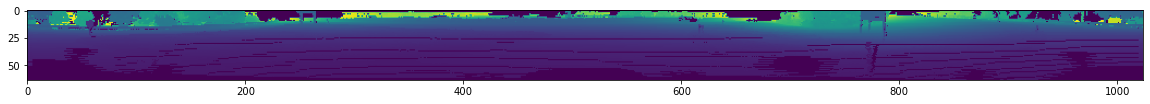

In [19]:
plt.figure(figsize=(20,20))
range_image = scan.proj_range
plt.imshow(range_image)
plt.show()

Repaired range image

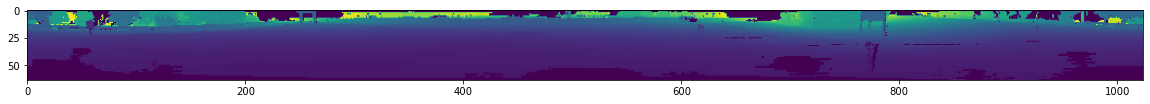

In [20]:
plt.figure(figsize=(20,20))
range_image_repaired = repair_depth(range_image)
plt.imshow(range_image_repaired)
plt.show()

Angles

In [21]:
angles, angles_filtered = compute_angles(range_image_repaired)

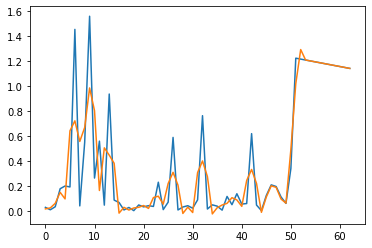

In [22]:
x = [x for x in range(63)]
plt.plot(x, angles[:,0])
plt.plot(x, angles_filtered[:,0])

In [23]:
ground_labels = label_ground(angles_filtered, range_image_repaired)

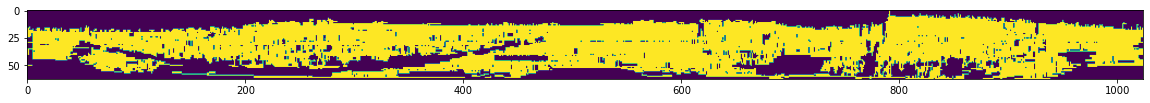

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(ground_labels)

In [25]:
invalid = np.where(range_image[:-1] < 0.001)
ground_labels = fill_invalid_pts_ground(ground_labels, invalid)

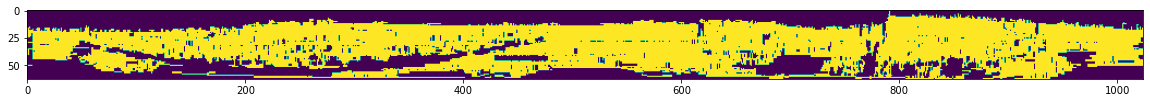

In [26]:
plt.figure(figsize=(20,20))
plt.imshow(ground_labels)

In [ ]:
ground_mask = np.vstack((np.zeros(ground_labels.shape[1]), ground_labels))

mlab.points3d(scan.proj_xyz[:,:, 0], scan.proj_xyz[:,:, 1], scan.proj_xyz[:,:, 2], ground_mask , mode='point')
mlab.show()

In [127]:
scan.proj_xyz.shape

(64, 1024, 3)

In [11]:
plt.scatter(pts[:,1],pts[:,2], s=0.001)

NameError: name 'pts' is not defined

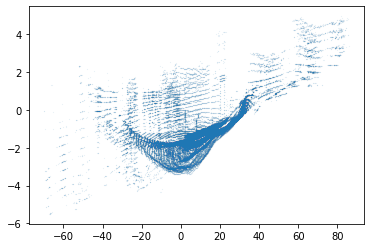

In [13]:
plt.scatter(pts[:,0],pts[:,2], s=0.001)

In [10]:
mlab.points3d(np.zeros_like(pts[:,0]), pts[:,1], pts[:,2], intens, mode='point')
mlab.show()

In [11]:
mlab.points3d(pts[:,0], np.zeros_like(pts[:,1]), pts[:,2], intens, mode='point')
mlab.show()

In [4]:
PATH = "../../semantic_kitti_data/sequences/01/"
file_name = "0" * int(6 - (len(str(0)))) + str(0)
scan = np.fromfile(PATH + "velodyne/" + file_name + ".bin", dtype=np.float32)
scan = scan.reshape((-1, 4))
intensities = scan[:,3]
pts = scan[:,0:3]

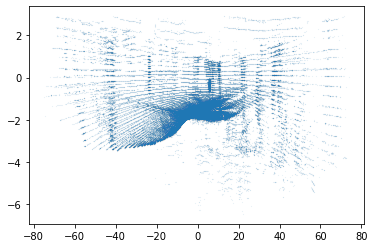

In [6]:
plt.scatter(pts[:,1],pts[:,2], s=0.001)

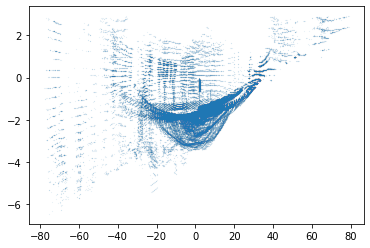

In [7]:
plt.scatter(pts[:,0],pts[:,2], s=0.001)